# Stack Development

We know that L = 4 reconstructs well with ternary r and predicted inputs.

The VPUWrapper is similar to our original stage - we now need to merge these.

We can start with audio data - 256 is a power of 4.

In [1]:
import numpy as np
import math

In [2]:
256**(1/4)

4.0

In [3]:
math.log(256, 4)

4.0

In [43]:
from src.var_processor.vpu import VPUBinaryZM

class Stage:
    """Object to represent a stage of processing."""

    def __init__(self, vec_len, stage_len):
        """Initialise stage.

        Arg:
            vec_len - length of each 1D vector processed by the VPUs.
            stage_len - integer indicating number of VPUs.
        """
        self.vec_len = vec_len
        self.stage_len = stage_len
        self.size = self.vec_len*self.stage_len
        self.vpus = [VPUBinaryZM(vec_len) for _ in range(0, stage_len)]
        # Create a blank array for the causes
        self.causes = np.zeros(shape=(stage_len, 1))
        # Create a blank array for the predicted inputs
        self.pred_inputs = np.zeros(shape=(self.size, 1))
        # Helper data to keep indices
        self.ranges = [range(i*vec_len, (i+1)*vec_len) for i in range(0, stage_len)]
        
    def forward(self, forward_data):
        """Forward pass through the stage (excludes cov update).
        
        Args:
            input_signal - 1D numpy array of length size.
        Returns:
            r - 1D numpy array of causes.
        """
        for i, vpu in enumerate(self.vpus):
            forward_segment = forward_data[self.ranges[i]]
            self.causes[i] = vpu.forward(forward_segment)
        return self.get_causes()
    
    def backward(self, r_backward):
        """Backward pass through the stage.
        
        Args:
            r_backward - 1D numpy array of causes of stage_len.
        Returns:
            pred_inputs - 1D numpy array of length size of predicted inputs.
        """
        for i, vpu in enumerate(self.vpus):
            feedback_segment = r_backward[i]
            self.pred_inputs[self.ranges[i]] = vpu.backward(feedback_segment)
        return self.get_pred_inputs()
    
    def update_cov(self, input_data, power_iterate=True):
        """Update covariance data.
        
        Args:
            input_data: 1D numpy array of length size.
        """
        for i, vpu in enumerate(self.vpus):
            input_segment = input_data[self.ranges[i]]
            vpu.update_cov(input_segment, power_iterate=power_iterate)

    def iterate(self, stage_in, residual_in, stage_feedback):
        """Pass data to the stage for processing.

        Arg:
            stage_in - 1D numpy array with data to process.
            residual_in - 1D numpy array with mix of predicted / original.
            stage_feedback - 1D numpy array with feedback data.

        Returns:
            r_out - 1D numpy array of causes.
            pred_input - 1D numpy array with predicted input.

        """
        self.update_cov(stage_in)
        causes = self.forward(residual_in)
        pred_inputs = self.backward(stage_feedback)
        return causes, pred_inputs

    def get_causes(self):
        """Return output of VPUs as array."""
        return self.causes.copy()

    def get_pred_inputs(self):
        """Return predicted inputs as array."""
        return self.pred_inputs.copy()

    def __repr__(self):
        """Print layer information."""
        string = f"There are {self.stage_len} units \n"
        string += f"with dimensionality {self.vec_len}x1"
        return string

In [154]:
from src.tests.vpu_wrapper import signal_pre_processor

# Testing a stage
size = 256
vec_len = 4
buf_length = 1000
stage = Stage(vec_len, size//vec_len)

# Generate fake data
data_in = np.random.randint(255, size=(size, 1))
mean = np.asarray([128]*size).reshape(-1, 1)

# Generate buffers for testing
input_buffer = np.zeros(shape=(size, buf_length))
pred_buffer = np.zeros(shape=(size, buf_length))
r_buffer = np.zeros(shape=(size//vec_len, buf_length))
residual_buffer = np.zeros(shape=(size, buf_length))  

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    # Process stage
    stage.update_cov(input_signal)
    causes = stage.forward(input_signal)
    pred_inputs = stage.backward(causes)
    input_buffer[:, i] = input_signal.ravel()
    pred_buffer[:, i] = pred_inputs.ravel()
    r_buffer[:, i] = causes.ravel()
    residual_buffer[:, i] = (input_signal - pred_inputs).ravel()

In [157]:
pred_average = (pred_buffer.sum(axis=1)/buf_length).reshape(-1,1); print(pred_average.shape)

pred_reconstruction = pred_average*mean+mean
error = data_in - pred_reconstruction

MSE = np.abs(error).mean(axis=1); print(MSE.astype(np.uint8), MSE.mean())

(256, 1)
[ 12 115  28 134  97 138 115 107   9 114  60 115 125 114  96 177 160   8
 126 101  46   9 204   2   9  49 189  93  93  90  65 154  26 120 128 158
 104 134  43  55   3  99 116   2 116   9  93  97 176  83 153 110  21 113
  75 111  82 127   0  38  45  14 161   9  40  88  55  57  20  53  40  73
  55 127  62 118  19  57  87  38  83  57  43  67 168   5  31  62  95 164
  91  15  20  73 134 149  45  37   6   4 113  20  63 101  10 141  80  71
  49   6  62 128  47   6  39  98  24  68  34 126   5 157  24  66  51  13
  98 120  69 189 139  82 187   0  54  89 213 112  80 109  33 129   4 115
 122  93  55   4  50  39 161  40 164  49 119  84  49 118 153 126   6  99
  81   2 133  36  44 112  16  28 112  41 169  37  73  46  44 107   1 123
  96   5   7  40 115 170   4  75  42 112 169  12  69   2  55 112  44  77
  34  34 172  84 145  44 129  12   5  52 111  38  56   6  99  18   1  29
 141 101 118  13 161 132  71  66  51  29  98  77  85 203  86  83  95   9
  31  80  69  20  32 149  49  57 116  41  

In [116]:
pred_reconstruction.shape

(256, 1)

In [117]:
pred_buffer.shape

(256, 1000)

<IPython.core.display.Javascript object>


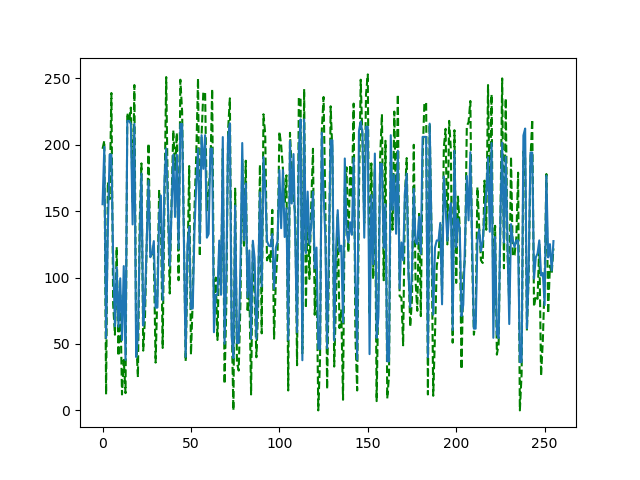

In [118]:
plt.plot(data_in, 'g--')
plt.plot(pred_reconstruction)

<IPython.core.display.Javascript object>


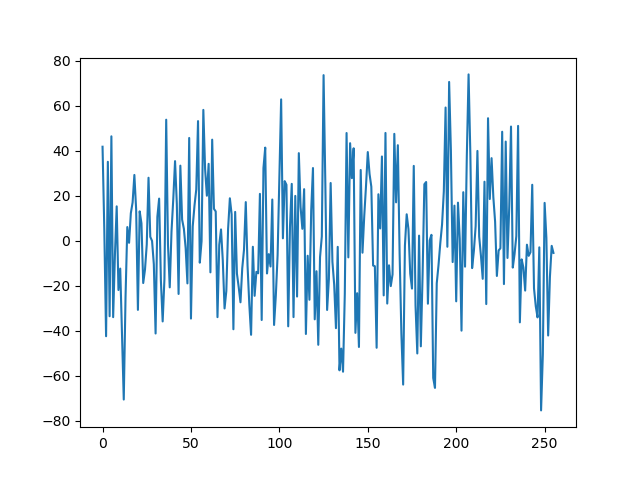

In [119]:
plt.plot(error)

In [121]:
MSE.mean()

23.528687499999997

In [125]:
print(causes.shape[0], np.arange(0, causes.shape[0]).shape)

64 (64,)


<IPython.core.display.Javascript object>


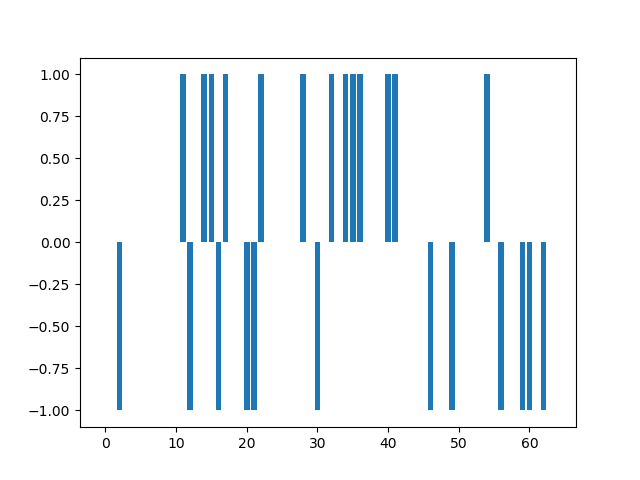

<BarContainer object of 64 artists>

In [126]:
plt.bar(np.arange(0, causes.shape[0]), causes.flatten())

In [127]:
cause_average = (r_buffer.sum(axis=1)/buf_length).reshape(-1,1); print(cause_average.T, cause_average.shape)

[[-0.574  0.505 -0.586  0.703  0.686 -0.564 -0.352 -0.396  0.353  0.541
   0.504  0.685 -0.401  0.538  0.619  0.54  -0.32   0.608 -0.692 -0.604
  -0.335 -0.579  0.49   0.302 -0.285  0.414 -0.585  0.54   0.712  0.287
  -0.638 -0.634  0.589  0.178  0.482  0.484  0.7    0.669 -0.573  0.45
   0.711  0.528  0.283  0.393  0.303  0.609 -0.687  0.103 -0.376 -0.527
  -0.445  0.379 -0.519 -0.064  0.489 -0.573 -0.575  0.492 -0.039 -0.716
  -0.517 -0.225 -0.381 -0.177]] (64, 1)


In [128]:
cause_average.T*128+128

array([[ 54.528, 192.64 ,  52.992, 217.984, 215.808,  55.808,  82.944,
         77.312, 173.184, 197.248, 192.512, 215.68 ,  76.672, 196.864,
        207.232, 197.12 ,  87.04 , 205.824,  39.424,  50.688,  85.12 ,
         53.888, 190.72 , 166.656,  91.52 , 180.992,  53.12 , 197.12 ,
        219.136, 164.736,  46.336,  46.848, 203.392, 150.784, 189.696,
        189.952, 217.6  , 213.632,  54.656, 185.6  , 219.008, 195.584,
        164.224, 178.304, 166.784, 205.952,  40.064, 141.184,  79.872,
         60.544,  71.04 , 176.512,  61.568, 119.808, 190.592,  54.656,
         54.4  , 190.976, 123.008,  36.352,  61.824,  99.2  ,  79.232,
        105.344]])

<IPython.core.display.Javascript object>


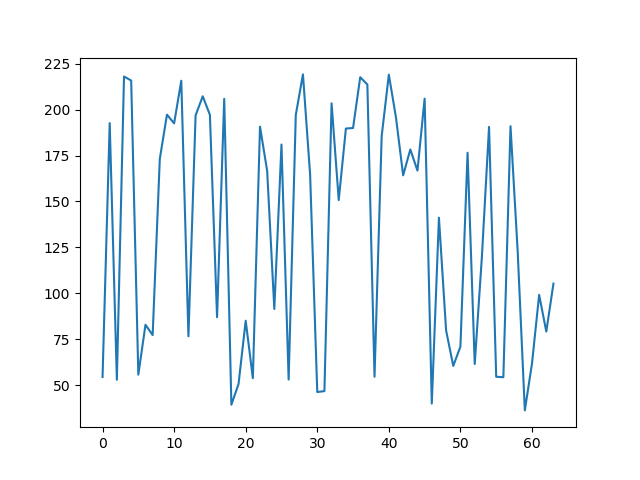

In [129]:
plt.plot(cause_average*128+128)

In [130]:
data_in.T

array([[197, 203,  12, 172, 159, 239,  80,  57, 123,  41,  87,  12,  38,
         13, 224, 217, 228, 157, 245,  54,  25, 141, 186,  45,  70, 126,
        201, 117, 118, 117,  36,  88, 166, 144,  47, 156, 251, 153,  88,
        156, 211, 181, 209,  98, 249, 225, 134,  37, 105, 184,  42,  83,
        152, 193, 250, 116, 207, 240, 239, 150, 167, 183, 242,  73, 100,
         53, 126,  92, 197,  20,  80, 211, 235,  68,   0, 167,  36,  30,
         82, 189, 124, 188,  74,  92,  12, 125,  90,  40,  78, 185,  58,
        223, 208, 113, 118, 112, 151,  54,  98, 121, 210, 200, 182, 157,
        177,  15, 209, 181, 159, 148,  34, 236, 234,  43, 242,  77, 158,
         99, 154, 197,  72, 109,   0,  39, 211, 236, 155,  16, 104, 229,
        194,  33,  81, 148,  62,  76,   8, 166, 183, 119, 185, 160, 231,
         56,  15, 163, 249, 203, 141, 238, 253,  72, 186,  99, 182,   7,
         91, 191, 223,  98, 203,   9,  26, 187, 136, 225, 150, 238,  86,
         85,  49, 162, 190, 108,  63,  84, 200,  98

To estimate the reconstruction, we need to:
* Sum and average the input and pred input buffers.

In [61]:
input_buffer[stage.ranges[10], 100]

array([ 1., -1.,  0.,  0.])

In [62]:
stage.vpus[0].pi.eigenvector

array([[0.60133255],
       [0.64726768],
       [0.45935125],
       [0.09187025]])

In [63]:
input_buffer.shape

(256, 1000)

In [64]:
input_signal.T

array([[ 0,  0,  0, -1,  0,  0,  1,  0, -1, -1, -1,  1, -1,  0,  1,  0,
         1, -1, -1,  0, -1, -1,  0,  0,  0,  1,  0,  1,  0,  0,  1,  0,
        -1,  1, -1, -1, -1,  0, -1,  0,  1, -1,  0,  0, -1,  0,  0,  1,
         0,  0,  0,  0, -1,  1, -1,  1,  0,  0,  0,  1,  0, -1, -1,  0,
         0,  1,  0,  0, -1,  1,  1, -1,  0,  0,  0,  0,  1,  1,  0,  1,
         0,  1,  0,  0, -1,  0,  1,  0, -1,  0,  0, -1,  1, -1,  1,  0,
         1,  0, -1,  0, -1,  1, -1, -1,  0,  0,  0, -1, -1,  0, -1,  0,
         0,  0,  1, -1, -1,  0,  1, -1,  0,  0, -1,  1,  0, -1,  1,  0,
         0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0, -1,  0, -1,  0,
         0,  1,  0,  0,  1,  0, -1, -1, -1,  0,  0,  1,  0,  0, -1,  0,
         1, -1,  0, -1,  0,  0, -1, -1, -1,  0,  1,  1, -1,  0, -1,  0,
         0,  1,  0,  0,  0,  0,  0, -1,  1,  1,  1,  0, -1,  0,  0,  0,
         1,  0, -1,  0,  0,  0,  1,  1,  0, -1,  1,  1, -1, -1,  1,  0,
         0,  0, -1,  1,  0,  1,  1, -1,  0,  0, -1,  1,  0,  0, 

In [65]:
causes.T

array([[-0.,  0.,  0.,  0.,  0., -0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
         0.,  1., -0.,  1.,  1.,  0.,  1.,  1.,  0., -0.,  0.,  0.,  0.,
        -0., -0.,  1.,  0.,  1.,  0.,  0.,  0., -0., -0.,  0.,  0.,  0.,
        -0.,  0., -1.,  0., -0.,  0., -0.,  1., -0.,  0.,  1.,  0.,  1.,
         1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.]])

In [68]:
causes.sum()

17.0

In [69]:
r_buffer.sum()

14420.0

In [71]:
assert r_buffer.sum() < 256*500

In [76]:
(input_signal - pred_inputs).ravel()

array([ 0.,  0.,  0., -1.,  0.,  0.,  1.,  0., -1., -1., -1.,  1., -1.,
        0.,  1.,  0.,  1., -1., -1.,  0., -1., -1.,  0.,  0., -1.,  0.,
       -1.,  0.,  0., -1.,  0.,  0., -1.,  1., -1., -1., -1.,  0., -1.,
        0.,  1., -1.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,
       -1.,  1., -1.,  1., -1., -1., -1.,  0.,  0., -1., -1.,  0.,  0.,
        0.,  0., -1., -1.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0., -1.,  0., -1.,  0., -1.,  0.,  1.,  0., -1.,  0.,  0.,
       -1.,  1., -1.,  1.,  0.,  1.,  0., -1.,  0., -1.,  1., -1., -1.,
        0.,  0.,  0., -1., -1.,  0., -1.,  0., -1., -1.,  0., -1., -1.,
        0.,  1., -1., -1., -1., -1.,  0.,  0., -1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0., -1.,  0., -1.,
        0.,  0.,  1.,  0.,  0.,  1.,  0., -1., -1., -1.,  0.,  0.,  1.,
        0.,  0., -1.,  0.,  1., -1.,  0., -1.,  1.,  1.,  0.,  0., -1.,
        0.,  1.,  1., -1.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0

<IPython.core.display.Javascript object>


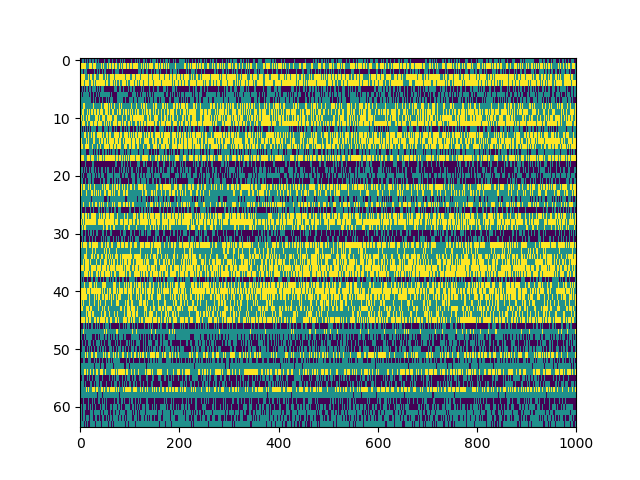

In [131]:
%matplotlib notebook
import matplotlib.pyplot as plt

plt.imshow(r_buffer, aspect='auto')

<IPython.core.display.Javascript object>


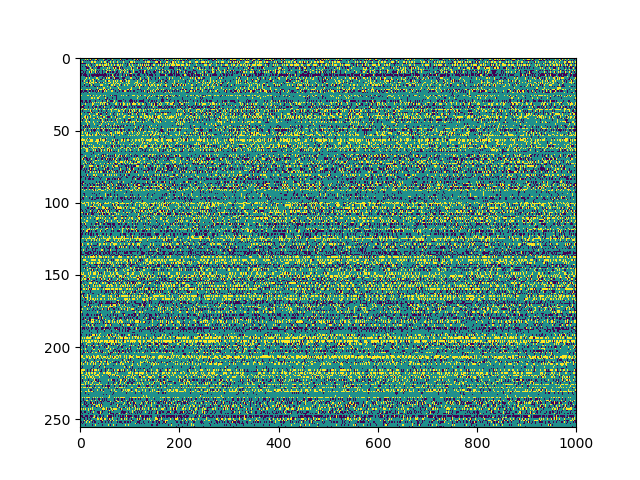

In [132]:
plt.imshow(residual_buffer, aspect='auto')

In [133]:
residual_buffer[:, 1].sum()

-5.0

In [170]:
4 % 1000

4

---
# Stage Test Wrapper

We can define a stage test wrapper, similar to our VPU wrapper.

In [181]:
class StageWrapper:
    """Wrapper for a stage to help testing."""
    
    def __init__(self, size=256, vec_len=4, buf_length=1000):
        """Initialise.
        
        Args:
            size - integer representing size of input data.
                Needs to be a power of vec_len.
            vec_len - integer representing the length of each
                VPU segment.
            buf_length - integer representing the number of iterations
                to buffer when testing.
        """
        # Testing a stage
        self.size = size
        self.vec_len = vec_len
        self.buf_length = buf_length
        self.stage = Stage(vec_len, size//vec_len)
        # Generate buffers for testing
        self.input_buffer = np.zeros(shape=(size, buf_length))
        self.pred_buffer = np.zeros(shape=(size, buf_length))
        self.r_buffer = np.zeros(shape=(size//vec_len, buf_length))
        self.residual_buffer = np.zeros(shape=(size, buf_length))
        self.count = 0
        
    def iterate(self, input_signal):
        """Iterate.
        
        Args:
            input_signal - numpy 1D array of length size.
        Returns:
            causes - numpy 1D array of causes.
            pred_inputs - numpy 1D array of predicted inputs.
            residuals - numpy 1D array of residual inputs, clamped at -1, 0, 1.
        """
        # Process stage
        self.stage.update_cov(input_signal)
        causes = self.stage.forward(input_signal)
        pred_inputs = self.stage.backward(causes)
        # Compute residuals and clamp at -1, 1
        residuals = (input_signal - pred_inputs)
        clamped_residuals = np.clip(residuals, -1, 1)
        i = self.count % self.buf_length
        self.input_buffer[:, i] = input_signal.ravel()
        self.pred_buffer[:, i] = pred_inputs.ravel()
        self.r_buffer[:, i] = causes.ravel()
        self.residual_buffer[:, i] = clamped_residuals.ravel()
        self.count += 1
        return causes, pred_inputs, clamped_residuals

    @property
    def pred_estimate(self):
        """Return signal prediction."""
        return (self.pred_buffer.sum(axis=1)/self.buf_length).reshape(-1,1)
    
    def reconstruct(self, mean):
        """Reconstruct an input signal.
        
        Args:
            mean - 1D numpy array of length size containing signal mean.
        """
        return self.pred_estimate*mean
    
    def error(self, data_in, mean):
        """Get error between original signal and prediction.
        
        Args:
            data_in - 1D numpy array of length size containing original signal.
            mean - 1D numpy array of length size containing signal mean.
        """
        pred_reconstruct = self.reconstruct(mean)+mean
        error = data_in - pred_reconstruct
        mse = np.abs(error).astype(np.uint8).mean()
        return error, mse
    
    def plot_buffers(self):
        """Plot buffer contents for quick check."""
        fig, axes = plt.subplots(2, 2, sharex=True)
        axes[0,0].set_title("Input Ternary Data")
        axes[0,0].imshow(self.input_buffer, aspect='auto')
        axes[1,0].set_title("Predicted Input")
        axes[1,0].imshow(self.pred_buffer, aspect='auto')
        axes[0,1].set_title("Residual Data")
        axes[0,1].imshow(self.residual_buffer, aspect='auto')
        axes[1,1].set_title("Causes")
        axes[1,1].imshow(self.r_buffer, aspect='auto')
        fig.subplots_adjust(hspace=0.2)
        plt.show()

[[-80.712 -18.664  50.656  30.336  32.552  -4.448 -10.552  -4.368  27.656
    0.     31.656 -42.344 -39.744 -25.52  -13.616  18.52  -33.      2.
   12.      3.008  23.552  58.768  29.824  17.32  -15.4     4.6   -16.592
   -8.816  23.184  -0.376   0.     45.544   2.36    8.112   2.36  -41.64
  -19.656 -10.68  -23.344   0.32   48.568  -4.568  10.992  -0.6    53.72
  -12.488 -87.928 -10.544  30.208   4.232 -26.784 -47.768  37.408  42.976
   -2.44   -5.28   -5.896  61.992 -67.536  18.208   5.48  -29.48   -2.52
   -1.376  35.392  26.8    -9.392   7.008  53.632  17.184  43.688  10.688
  -60.384  34.832  64.392  29.168  22.776   6.344 -14.36  -29.056 -36.912
  -17.56   37.088  -1.912  78.2    17.464  23.536 -23.528  13.848   9.008
  -12.848  -7.152  44.208 -11.824  37.336  23.08  -16.592   1.72   22.624
  -37.528 -21.424   6.088 -12.976 -42.088   7.72  -13.28  -35.28    4.872
   33.752 -36.528 -19.752   0.888  29.128 -13.128 -41.872  53.384   4.488
   17.28  -48.72  -11.848 -18.192  18.192 -1

<IPython.core.display.Javascript object>


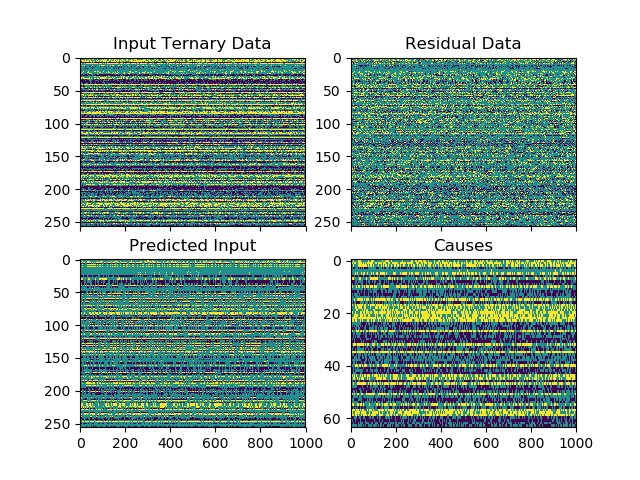

In [182]:
# Initialise stage wrapper
size = 256
vec_len = 4
buf_length = 1000
wrapper = StageWrapper(size, vec_len, buf_length)

# Generate fake data
data_in = np.random.randint(255, size=(size, 1))
mean = np.asarray([128]*size).reshape(-1, 1)

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    wrapper.iterate(input_signal)
    
error, mse = wrapper.error(data_in, mean)
print(error.T, mse)
wrapper.plot_buffers()

The causes are a form of downsampled signal. These visualisations are nice.

Let's see what happens when we supply truly random input data - we can compare with above.

<IPython.core.display.Javascript object>


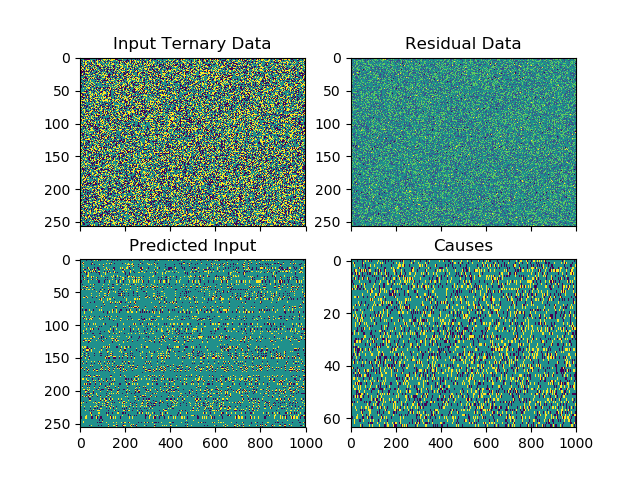

In [173]:
# Initialise stage wrapper
size = 256
vec_len = 4
buf_length = 1000
wrapper = StageWrapper(size, vec_len, buf_length)

data_in_buffer = np.zeros(shape=(size, buf_length))

# Generate fake data
mean = np.asarray([128]*size).reshape(-1, 1)

for i in range(0, buf_length):
    # Generate fake data
    data_in = np.random.randint(255, size=(size, 1))
    data_in_buffer[:, i] = data_in.ravel()
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    # Iterate stage
    wrapper.iterate(input_signal)
    
#error, mse = wrapper.error(data_in, mean)
#print(error.T, mse)
wrapper.plot_buffers()

Cool! It tries to find patterns in the noise, but the causes still end up as noise.

---
# Test Reconstruction Over Multiple Stages

For a vec_len of L we (should) need L stages to reconstruct the original signal.

So we take the stage residual and feed that to a next stage. We then sum up the predictions as before - we should get more accurate with each stage.

In [184]:
size = 256
vec_len = 4
buf_length = 1000

residual_array = np.zeros(shape=(size, 100, vec_len))
sum_err = np.zeros(shape=(size, 100))
for i in range(0, 100):
    # Initialise vec_len stages and wrappers
    data_in = np.random.randint(255, size=(size, 1))
    mean = np.asarray([128]*size).reshape(-1, 1)
    # Generate vec_len stage wrappers
    wrappers = [StageWrapper(size, vec_len, buf_length) for _ in range(0, vec_len)]
    for _ in range(0, 1000):
        # Iterate over stages
        input_signal = signal_pre_processor(data_in, mean)
        for w, wrapper in enumerate(wrappers):
            _, _, residual = wrapper.iterate(input_signal)
            residual_array[:, i, w] = residual.flatten()
            input_signal = residual
    
    pred_estimate_sum = np.asarray([wrap.pred_estimate for wrap in wrappers]).sum(axis=0)
    scale_factor = np.minimum(mean, 255-mean)
    est = (mean+pred_estimate_sum*scale_factor).astype(np.uint8)
    sum_err[:, i] = (data_in - est).astype(np.int16).flatten()
    print(f"Iteration {i} - \nData: {data_in.T}\nEstimate: {est.T}\n\n")
MSE = np.abs(sum_err.astype(np.int8)).mean(axis=1); MSE

Data: [[ 15  77 190 120   8 184 192  75 152  87  25 207 101   7 120 135 190  25
   89 219  24 248 203 200 126  84 230  57 206  86 188 233  18 120  29  54
  253 100  20 226 214  66  20  28 253 204 120  19 204 199 197  75 158 107
  166  94 129  68 130 174 116  35  54  83  44  61 234 246 239  18 205 241
  144 100 190  76 159 209 102  78  55 123 148  69  51  12  49  33  89  48
   68 132 178 164 224 250 153 231 156 113  89  72 142 109 142  98 106  52
  127 165 253 229  65  95 242 157  91  16  72 166 136 202  30  17 248 163
  152 106 133 173 108 153 158  74  98 181  43 167 252 229 152 201  34 107
   78  54 139  98 112  70 213 152 242  52 118   4 157  47 157 193  20 144
  198 109 139  64  83 245 195 194  54 233  45 128 176 187  56 119  40  67
   95 120  76 164  94   0 182  93 166  46  31 251   0 111  56 143 221  47
   85 166 250 129 242 138 128 233 113 212 117 246 178  94  73 130 101  48
  134   4  55 219   6  75 161 192  57 234 187 168  60 123  26  78  14   9
   38 251  51 156 100 248  23  6

Data: [[153 121 150  10 222  16  85  25 117 151 198  74 119 221 127   9  92 144
  249  79  43 118 203 169 184 241  64 195 127 216 208 101 232 249 141 180
   98 231  27 250  67 184 187 109   3  77 192  13 206 175 231  34  63  34
   31 129 139  60  30  27 238  56 171 222 142   3  68  91 151 217 158 113
   86 197 228  71  29 131  76 224  25 203  66 242  24  15  86 112 247  40
   68  39  69  14 113  77 249  60 103 190   7 211 114  80 154 242 107   4
  141 254 225 227 141 111  61 227 128   9  89  58 231 253  50 199 202 202
  101  39  21  58 181 100 144  47 185 250  89  24  20 104  84  38 152 128
    6  73 158 143 180  76  63 181  14 115 131  63 135  53  94 189 198 243
  171 158  71 148  38  87  15  50 116   4  89 110  86 169  91  52  53 203
  243  60  62 223  70 230  15 218 153  52  53 211 247   3  59 180  64  19
  147  25 243 187  67 130 178 152 180  49 116 251  65 220 225 235 194  35
  226  96 239 253  67  42 246 248 168  49  37 250  84  77  56 254  72 214
  240   8  64  58 106 167 180  1

Data: [[ 77 184 215 153 219 159 150 193  21  80 111 237  33  62  62 107 203 232
  210  98 111 107 119  57 110 171 129 182 170  41 157   8 152  97 240 168
   31 101 139  66  21 239 232 118 179  30  33 174 183  13 159  48  47  68
  194  78 240  36  18 220 108 122 104 253  81  29  73  15  24  52 173 225
   42  71 238 234 104 206 249 128 222 121  93  29  97  51 216 248 120 177
   37 148 189 162   3  31  11 151   7 123  92  22 117 163   8  57  73  98
  184  40 100 123  99  71  32 249  31 152 230  76 149   5 126 117 130  75
  114 157  17  57 130 200 132 245 144 183 144  80  10 244  30 208 113 216
  112 239 109  32 216 147 172 254  70  54  32  55   2 182 129 209 197  29
  184  26 246  37 109 253 152 223 158   5 180 243 161 254  36  89  46 179
   11 244 138 139 118   2   1 208 152 108 178 137  85 156 117   2  21  59
  105  50 126 151  46  17  66  69   2  96 129 123 194 117 204  90 199  40
  233 104 233 231 240 235 247 191 154 173 140 120 132  62 236 204 158  69
   11 253 149 184 176  76  88 16

Data: [[188 148 129 123  31 185  32 105 254 199  21  15 241 178 145  60 103 165
   92  15  19  68  58 173   9  65 183 104 173  61 106  11 252 198  88  13
  110  54 140 251  95 105  23 126 193 230 121 211 207 166 137 203 190 121
  228  83 174 136 166 125 201 148  62 133  88 160 120 103 154 216 116  31
  115 250 139 216 232 232 155 244  97 225 244  88 138  74 113 233  17 216
   85 174 244 127  80 158  14  76  80  23  80  73  79 190   3   7  57  31
   45  55  94  41 136  71 226 181 231  58  90 246 191 194  78  42  83 150
  212  75  55 102 254 107 166  43 147 186 175  47   2 237 138 186 162  84
   87  89  72 241  73 155 195  80 242 206 238   8 146 163 100 102 103 158
  213 192  14 195 126 123 214  72  24  83 232 164 102 156 218  44 132 124
   23  82 144  75  74 188 221 165 227  70 112 173 135 251  78 106 151 197
   31  36  79 183 187 252 150 122  43 159 223 212 166  23  38 249  19  76
  240  64  56  20 148 170  62  56 123  84  58 225   5 247  68 223 232  52
   61 140  25  96 199  85 224  4

Data: [[199  91 157 154  60  69  93  45 223 139 114  55  91 172  50 101 208 187
   44 239  73 114 135 218  81  90  86  95 176 178  23  30 195  31  26 116
  218  50 247 108   3 166 179   9  27 136  31 128 174  55  42   8 143 184
   69 205  49 224 136 139 100 243 201 223  60 172 156  94 193 109  13  19
   16 159 221  71 167 228 198  29  84   0  28  80   4 220 133 210 233  80
   74 104 154 231 249 241 216 239  64  43 238  22 156 219  42 204 110 238
  155  53 100 244 149  98 203  37  19 169  95 130 112 238 217  57  34 213
  117 158 116  95 172 237 241  82 238   2 216  67 221 126 110 216 212 182
  243  23 132 146 176  53 194 163   4 180 241 116 196 239 111 146   6  62
   56 134  92 110 163  15 106 226  59 130 231 148 110 175 174 166 205 101
  184  74 223 212 225 183 110 169 249 137  78   0 130 244 193 129 135  82
   53 120  64 145  76 195 253 171 163 211  54 127 212  18  40 116 146 104
   38 116 167 116 117 104 182  71  28 124 112 139 159  82  31 116  98 163
  106 253 163  70  73 138  32 25

Data: [[ 79 183  57 152 164  85 234  13  54  47 232 167 145  64  20  72  12  72
  246 247   9 196  56 125 148 227  17 222 178   0 222 132  90 152 106 210
  254 247 194 135  16   7 237  89 222  88 219  63 198 108 181  15 185 136
  222 154  25 226   9 244 198  22 225 241 235  40 212 147  64 128  91 192
  178 149 170 187 160  60  13 136   4 210  14 204 144  25 193  33 184  61
  152 224 110  42   1 244 230 148  94 177 143  74  96 109 215 125 181  56
  230 202 245 195 107 167  30  17 144 125  80 108   9 230  73 223  96  56
  229 236  31  93  45  35   3  95  66 205 122 206 215 131  38 159 243 154
   42 193 220 106 178 177 157 211   2 148  89  95 183 162  97 101 201 113
   94 213 210  75 234 156  94 232 126  35 244  83 121 206  72 182  86  94
   68 108 152  94  51 215  95 204 231 242  93 135  69 122 112 108 103  25
  133 108  90 100 230 226  91 216 174 124  97 112  86  64  51  65  92  25
  163 191 238 183 180 142 182 189 159 232  36  26  79 247  24  34 191  60
    6 168  41 158  81 241 180 18

Data: [[ 35  51  54 103  27  84 171 118 247  72 129  47 217 165  53   4 194 138
   43  75 178 154 251 176  14   7 160 238  79 167  89  68  19  16 173 193
  112 218 204 199 177 241 219  58  77 231 187 158  73 220   4  52  68 125
  241 252 198  78 191 120 192 218   0  15  39 149 100 212 166 138 151  17
   82 150 111 104 225 193 206 157 153 187  86 164 115 147 208   4   8 124
  248   6 219 189 172  34  75  77 149  65  53 175  64  14  84 105 240 248
  154 138  33  70 173  25 146 203 225 249  82 121 161 188 237 129  43  71
  157 169 159   6  72  80 128 229 113   9  56 104  59  73 148 221  36  20
  162  53   6 159 105 217  77 191  87  88 150  30 128 196  34  65 191 193
   71 111 100  72 217  36  16 141 159  58  52 110 105   6   8 243  97  30
  216 169 242 160 131 240  19  84  23 131  16   0 163 247 127 237 110  22
   22 111 243 161 195   7 237 246 193 125 141 215 148 228 127  21 231 221
   69   8 218   6  92  86 246 136 152 184  65  50 253 164  50 196 176 252
  110 104  44  66 212  91 128 13

Data: [[114   0  31 228 218 213 166 113  30  53 144  57 138 102 197 141   0 250
  182 217 179  18 241   1 162 191 245  95  57 113 220 107 216 239 179 180
  216 249 230  90 175 180  21 175  19 188 179 228 114  99 162 104 246 167
  132  86  43  83 146 250  91  68 211  16  76 108  76 162  48  35 122   7
   51  28 118  92  84 110  75  55 219  90 112  30  40   8  16 240   1 211
   20 237 240 161  57  65 220 139  54  92 115 235 210  66 189  32   4 115
   74  34 242 137 121  44 139 124 247 129  11 208  14 184  65   0  96 101
  208  36 227  28  15  14 218   4 227 100 151   2 111 117 252 142 125  97
   55   3  48 223 239 249 108  45 206  66 254  88 210 228 227 186 109 159
  165 102 135 164 170  64  43  12  60  20  48 186 139 110 238  59  82  92
  125 103 103 102 165 150 100  40 155 212  78  38 208  57  75  39 220  33
   99 244 216   2  85  99 224 217  48 105 183 195 214  13 125 134 129 179
  170  63 211 126 230 123 135  96 211 160 133 171 139 150  28   8  12  91
  177  17 243 115 171  65  12   

Data: [[240  94 155 194   6 180 236 117 164 121  81 115  91 242 117 105 161 126
   54 171 234 184  82 202 139  96  36  89 228  72  25  14 119  35 242  87
  195  91 136   4 110  26 132 148 212  28  12  92 178 204  97 136  13 199
   38  23 225 187 125 157 172 241 138 254  34 102 124  16  92 173 136  70
   42  92 243 210 175 251  98 250 116  39 175 201 164 203 132 143  13 122
   44  31 158  96   5  63 251 199 143 103  62 171  71 224  93 120 193 204
   10  29 132 202 248 223 116  22  39  16 152 139  97 199  34  17 182  38
  248 142 103  48  20 100  13  70 103 171 154 200 108 152  97  49  81 101
  199  79 182 125 193  75 166 120 162 220 141 163 187 159  65 229  75  27
  172 214  68 155  90 186  86   2 241  37  41 177  77  72 207 239 151  93
   99 219 169 189 201 114   2 111 127 128 152 147 231 159  88  16 202 105
  199  13  92 170  29 158 201  62 211  36   8 203   1  35  87  30 155 217
  235  20 117 244 129 119 229  98 238 202 160 166 242 206 238 124  38 105
  193  51 216 226 102  95 107  5

Data: [[  7 196 160  28 142   7 147 122 156 196 177 204  49 223  99  67 219 134
  118  79 112  20  36  59 142 127  61 145  45  82  71 132 209  87 118  39
    8  80 158  47 236 137 116 120  21 110 140 122  38  25  36 214  95  45
   27 127  34  67  97 222 136  76  51  52 221  51   1  38 252 234  81 139
   99 147 155 139 187 108  26  59 183  52 200  65 133 231  89 137  62 158
  151 229  57 183   7  19 124  79  49 192  43  89  88  62 222  49  63 139
  196 130 151  82 176 180 227 215  84  10  15 225 113 106 181 205  41  89
  162 116 191 211 119  51 228 130 199 243  22  88 224  42 141  74 103 131
  223 170 203 115 207  59 114 232  60 137   7 249 186 120  28 220 160 148
  151 167 157 103 100  13  20 164 175 236  60 117 206  18 112 114 113 137
  229 222  36  84 215 166  25 236  96 163  16 133 166 148 173 171  52 229
  182  81  53  64 144 183 215  91 152 231 241  71 220 252 220 147 127  19
  137 238 167 231 146 166  92 221 197 225 101  90 163 129  19   8 122  29
   15 157 149  60 137 220  19 13

Data: [[198 156  50 252  31 224  79 228 134 192  21  64 117 183 156  64 187 105
  131 158 185 171  16  79 117 113 121 224  14 114 216 249 228 168 191 224
  102  93 169  29 206  92  63  89  72 146  31 138 176  90 115 182  22 201
  220  16  48   2 106  43  83 150 242 217  12 161  51 172 124 124 112 134
  253  43  34  90  34 210  22 131 176 179  18   9 107 184  87 180 111 101
   90 190 250 103 223 203 196  59  99 186 226   9   9 249 178   3 233 153
   59  31 131  59   5 196 250 196 211 164 163 241  19  95  11  53  35 138
  139 209  47  42 118 178 248   1 189 149 196 102 105  98 172 133 120 189
   26 147 143 245 199  50  69  58   2 138 170 244  26 185  55 104   1 127
  253  38 225 114 207  24   4  74 188  26  55 134 183 185  34 114 130  67
   89 180  86  23 205 158 183 212 215 180  20 167 100 246 158 243  45 204
   11  73 227 153  51 218  70 108 205 114  82  89  94  23   2 225 181 115
   86  66  21 232 206  89 151  54 193   0  87  66  81 194 199 249 129 206
  158  97  81 114 252 210  38  8

Data: [[ 25  72  49  89  62 134 235 180 242 254 219   8 181  37 155  39  16 220
   85  81  88 216  52 171  38 197 251  45  85 238  42  30 169   2   3  34
   95  65 121 211 171  76  55  70  89 223  74  84 216  30  22  42  16 114
   38  11  73 136 145 185  35  53 179  52  47 105 176 208 180 148 142   8
  119  67  39 165 139  66 136 174  72  32  61 118  13 229 141  37 214 188
  122 201  46  47  44 239 153 147 187 215 251 179 171 181 211 100 159  40
   60  68 104 140  89   6 166 161 123 219 170 102 236 235 226 160 222 195
   48  59  72  54  19 155 130  42  56 158 104 134 156 137 215  78 139 143
  208 209 221  95  90  62 129 147 175 244 187  55 176 167  79 198  96 121
   97 187  71 137  39  51 136 160  28 160 156 153  52 145 154  71 149 226
  140 193 141  62 167 156 211  90 100  97 131 190  59  69  33 150 151 226
  128  27 169 206 106 153 229 237 219 140  86   6  53  49 167 130  98  46
  180   3 158  98 247  87 191  54 172 230   4 102   9 108  70  77 157   2
  149  80   1 244 149 204  38  6

Data: [[ 55 254 136  49 132 166 184  82  76 231  23 162 116 249  52  56  83  93
  149 159  26 194 129   3 178 240 167 105 190  95 234 125  80  51  45  44
  177 250 189 244 179  19  98 198 171  87 229 206 187  43 137 165 125 221
  152 161  53 221 157   8 182  87  78 164 215  16   2 238  86 201 129  96
  183  27  16 234 102  45  50  42  78 238 164  32 194  69 126 148 131 185
   28  28 216 132 151 184 172  46 159  56 159 188 207  48 149 202  72  88
  254 111  16  63 115   6 186 128 118 108 104 247 184  97 135   2 201  99
  103 137 224 105  82  11 116  32 105  34  11  23 173 113 199  97  80 129
  225 240 203 106   2  72 107 139  10 205  28 187 127  89 133 104  16  47
   35 198 248 228 156 155 208 230 221   2  35 125  80 102  60 165 112  53
   95 108  80 196 236 199 217  91 211  10 145  24   8 179  28 126  82  96
   68 238 211 210 194  14  26 253  56 113 180 140 146 148 158  67 169  63
   32 113  47  15 154  87 136 176  79 223 125 184  13 100 215 130 214   7
  135  34  54   7 155 164 216 21

Data: [[180 176  91  90 233  19 203  72  85  21 232 222 161 194  17  98  10  93
    7  70 154  52  63 227 146  67  74 115 180  20 156   8  58  67 192 111
   23 222 114 184 243 129 250 192 115 116 152 156 174  23  61 128 156 111
  246 158 182   2 197  67  32  56 240  65 221   1 237 104 236 225  87 124
   44  29 106 194   1 109 151 196  59 115 118 232 161 153 103  45 140 111
  164 103 248 175  36 221  55 124 178  68 237 215 215  13  61 252 113  22
  119 200  53  61 176 112 157  93 160 140 155 251   3  55  25 177 245  81
  216  90  90 187 215   8 191  74 225  96 165  66  41  61 208 247  96  15
   38 176  76 144   3 119  35 175 175 241  77 141  71  44  14 168   7  24
   97 137  35 163 236 192 168 156  40 158 140  32 227  11  12 193 203  47
   33 106 187 169 129 149 225 173 191 119  21  21  11 129 132 110 103  53
  112 248 101 201 136 219  35 217  10 164  17  92  91 214 240 183 229 136
   18  56  93 207 250 190 124 185 204  61  21 251 144 179  71   4 247 177
  217 134 128  87  10  21 192 22

Data: [[133 119  48 232 154  46 227  17  24  80 177 189 188 181  12 162  72  72
   19 159  98 114  69 176  58 142 180 249   6 113 188  65 194  97 234  14
  197  87  53 213  84 207 228   0 114  92 168 141 143  17 188 224  81 142
   43 225 162  38  42 248  69 145  26  44  81  18  22 184 252 124  62 156
  170 217 205 209 138 238  35 120 101 104  68 131  35 216 195 137 117  36
  163 205  87 158 155 129 243  19   7 170 227 131 149 185 187  83  91  80
  111 189 233 157 153 240   8  13  79  67 205   3 251 113   8  18 124 100
   98 105 201 105  76 248 214  92 107 158  16 190 135  13 114  57  40 235
  157 138 197  41  27 124 231 150  82  61 160 161 149  94 151   8   0 173
  228  66 133 117 247  38  86  81 191 136 200 137 231 204  84 174 159 120
    5  59 230  32 107  30 236 204 226 105  48 191 153  45 159 102 238 235
  229 243  92  87  46  95 222 214 248  80  97 117  68 149 253  29 115 144
  189 156 237 135  26  46 201 124 153 208  28 233 190  29 160   0 133  34
  230 113 156 211  10 133  78 20

Data: [[ 40  91   5 218 221 129 105 241  40 134 128 153   4  17 104 209  91  11
   19   4 106  28 139 224 241  58 181  96 180 151 206 198 209  38 192 238
   39 136 183   0  92 127 246  11 205 213 160 127 172  24 202  18 200 117
   82  23  58 179 254  49 119  47 178 231  14 192 103  49  87  91  83 207
  216 119 178  21  11 162  46  78  94 108  46   0  54 216  39 183 113  77
   43 104 112  91  23 254 236 139  37  86   3 239 183  83 160 230 105 229
  213 119  62 132 214   0 251 181 166 181 108  49  82  76 196   7  47 196
   82 139  13 216  27 133 235  74 211 111   1 176 148 210  94 143 130  64
  206  21 140 189  89 126 130 235 188  29 233 174 254 107 211 155 213  63
   25 241  73 112  73  53 121 202 153 113  82 141 172 142 142  77 145 173
  127  27 205 196 105 107 130   7 136 229 201  53 143  34 127 233  97  69
   24 244  72 191 165  48 173  39 104  60 220 131 211 186 162 163 196 244
   67 216 248 188 118  82 126 130 212  50 235  12 215 202  16  78 207 118
  165 192 221 149  46 208 225  3

Data: [[108 227 125 201  24 113  31  62 214 235  41  16 192 222 245 101 107 114
  194 117 139  84  65 249 154   6 201  85 248  49   0   9 153 233  94 205
  149 153  37 178 177 102  46 149 136 164  12  36 252  11 125  15  34  35
  222 217  50  42  38 127 121 113  78  50  59  60 101 174 192 143  34  72
   19  57 228  80 254 228  21  69 193   7 235 166  55 150 253 251 154 170
  210 184 197 249 119 169  40   5 138 197 185   1 184 140  43 155  60 182
   93  97  94 148 243 135  44 209  84   6 127 199  48  85 129 157  94 148
  242 146 114 164  70 252  33 135  79 169 202  98 231 112 151 249 202  72
   86  39 171  76  97 167  80 175  65 239  21 157  36   7 216 133 172  23
  178 184  84  14  69  29  30 221  82 241 218 162 236  62 140 230 197 175
  114 202 160  20  45   1 109 251 148 204  62 169  34  31   9  59 184 155
  158  55  76 249 126 210  91   2 232 163 206  31   6 192 183 212 183 163
   40  15 226 175 131 140 231  60 228 193  23  41 247   6 214 155  17  78
   79 159 228 248 193  24  74 13

Data: [[ 97  31 184  12 133 122 206 191 247  58 145 104 240  70 142 208  52  11
   72 254 246  45 100 109  64  83 135 193 166  78 124  18 143  59  38  76
   99 158 228 215 224 210 102  55 193  62  77 177  80 216 222 247  84  88
  104  59 248 139 242 205  28 121 178 160  37  36  81  59 120 189 141  12
  186 138 102 103   7  47  39  21 140 168 231 134 193  34  54 196 104 253
  115 196  47  44 122 168  80  53 169  87 149 144  62 214  42  90 166  64
  162  70 196 231  46  72  35   5 109 202 160  25 212  48 192 169 100  92
  109 139 144  15 148 228   8  75 175  25 110  66 147 157 191  58 168  53
  181  33 194   3 132  36 183   0   3  16 100 236 137  31 254 147 211  72
  185   5  37 244 168   6 123 176  38 134  93 173 113  27 118 106  49  48
   90 209 157 236 206 132 149 124 224 198  31 206 109  80 175 211  43  23
  169 189 244 131 111 196  79 176 132 131  93 194  25 207   8  54 195 110
  223 175 127 157   7 254  70 171 238  95 106  56  33  72 243  48 156 137
   64  59 250  71 250  79 201  8

Data: [[113 178 198 178 254   6 151 100  40 233  43 217 117  27 210  14 170 235
  106  95  59 151 254 176 120 179 150   7  20 172  27 207 227 175  44 108
  152  29 149 170   3  71 130  27 224 217   5 249 187 101 109  75  54 111
  163 178 218  80 185 139 252  27 176  95  21  66 209 198 243 112  41 197
   74 248  88 238  53 190 114  44 137  51  15  56 188  79 228 254 175 124
  167 144 114  35 165 125  24   7  24  37 244  68  52  54 212 166 169 108
   91 117 197  88 195  70 177 247 107  66  80 182 235 117 199 168  36  92
  107 169 125 197 171 195  21 120  20 109 165  71  45  65 141 231 216 209
  246 107  89 141 163  41  47 186 133 105   3 239   0  11 143 252 156 220
  250 135 235 184 196 148  49 170 247  51 244 137  63  87 205 210 130 154
  207 124  59  93  91 120 185  23  90 136 102 240 171  83 156  31 229 147
  133 158  40 176 237 191 196  86 166 177  59  94  42 129  80 169 202 220
  246  43  75  79 183   1 160  85 156 205 204  57 100  89  74 165 215  40
   64 137 215   6  80  52 244  7

Data: [[165  60 174  83 251 218   9 183  64 114 107 132 229 250 101 103 199 224
  193 222 121 200  28  82  81 140  91  26 251 124  31  43  77  34 229  26
   56  74 181  25 184 104 204  52 244   6 239 177 214  60 206  64 103 219
  161 234  71 173 216 234 226  64 250 108  42  15  92 168 211  33 102  85
   58 168 144 136  80 211  11 157 166 149 137  19 220 189 104 232 162 116
   49 245 161 145 233  68  55   2 237 234 183  78  46 149 219  80 237 130
  220 133  46 199 228  84   9  34  13 203 117  82 122  79  34 146 251 170
    6 138 125  51 116  65 234  44  72  72 124 151  76 124 126 176 189  33
   87 100  83  93  73 197  53 248 171  35 251  24  56   2  32 130  85  49
  137 170 154 252 149   9  82 208  47  73 241 238 193 150 105  88  91  77
  115  72 169  69 129 134  20  48 209  55 143  11  80   7 207  32 195  20
   52  55  88 144 201 234  87  71 238  64  74 193 215 202 133  30 145 190
  115  32  43 227 107 184   1 145  46 167 118 242 144  79 240  66 228 192
  179 148 154 218 182 211 170 19

Data: [[219 122   4 249  66 207  67 181 119  91 203  54 124  58  94  57 207  47
   44 119 252  16 140 195  42 185 230 143 215 206 141 239  39 162 217  24
  198 166 219  48 213  81   6  12 137 146 116  56  20 214 155 185 103 144
   81 192 135 167 181 179  63 199 172 244 137 235  39 224 198 136  31  47
  252 182  59  86 232 244 166 114  81 103  27 139 193  50 103  69  69   5
  146 191 244 144 137  49 120  37 102  58  50 202 135  10 115 131 131   1
   75  56  32 240  65 133 152  38 244 239 114 127  98 249 186 248  21 174
  211 229 191  62 115 145 196 229  18  58 234 156 139  23 132 140 116 251
  173 195 238  10 148 183 134  77 223 112  28 145 108 165 153  16   0 145
   63 245 109 195  68 232   9  89 116   2  78 190 222   4 254 211  60 172
  225 163 195  30 108  64 225  54  63 213  56 178 148 170 219  21 232 117
   16 153 203  28 203  40 253 172 103  59  34  18 114 165 162 235 106  53
  173  75  55 156  13 182  26 101  92 150 114  52 111 218 222  11 144  64
  157  34 144  17  42 168  26 16

Data: [[ 37 250 215  37 128 177 189  95  79 171 174 223  73  70 147  30  92 122
  197 158  17  10 195 246 103   1  63 173  51 179 223 108  46 185  86  58
   76  12  51 212  10  77  56 119 220 118 115  81 223 152  63 160 243 203
  224  57 162  77 160  38 160 208 167 221  43  74 111  50 186 145 214 136
  230 228 134 175  17  93 121 236  46 138  26 207 253 213 191 110 241 154
  152 202  53 135 166 122  93 214  90 226  10 235 152  63 170  35 183  22
  116 210 116 113 129  66 146  19 234 114 176 186   2  58 241 115 223  17
  244 104  22 191  29  94 103  54 124 109 114 210 252 112 157  77 244 210
  209 129  52 249  99   9 215 163 235 240  83 194  12 241 145  44 210 152
  150 120  49 192 129 168 153 184  90  98 153 186 233  47 203 188 203 228
  114  43  99 195  13  13 139  46 173 199 226 150  75  65 243  71 243 204
  105 211 234  30 104 176 180   2 205   2 219  38 190  59  59 161 153  38
   50 230 167 190  82 179  17 116 114 128 202 161 187 221 180 231 165 168
  192 105  67 110 115 233 144  3

Data: [[102  43  62 237 139  43  61 209 155 254  13  58   8  55  38 238 100  47
   20  28 106 103 103 108  64  86  80  42  36 104  63  76   4  30  34  54
   30  33 142 155 177   0 157 241 248 227 136 194  88 227 148 101 228 143
  191  56 233 156 123 207 163 103  17   2  97 244 179  79 146 190  38 166
   21 163 236  72 211  14  86 254 151 251   8  55  95 131  46 154 246  67
   94 203 174 129 119   4   5  32 185  63 122 209  48 174 117 120 167  99
  240 188  92  72 205 100 200 191  95 143 138 214   2  12  53  68  69 210
  121 130 236 111  94 207 134 165 174 162  20 177  72  18  42  17 155 225
   63  10 154 197 233  15  63 123  12 242  95 166  53 167 192  35 186   6
  158  26 149 111 167 139 143 201  16 215 110  13  65 138 252 249 179  56
    6 181 116 204 224  44 252 204 169 203 217 212  17 139 223 161 229 199
  249  14 182 124 117 179 226 202 136 162 143   6 252 217 226 163   6 175
  216  94  38 241 105 106 150 249 110 173 190 121 211  23  19  89 175 221
   41   4   3 170  25   4  55  5

Data: [[189  75 253   9 148  47 106 192 228   1 185 224 139 179 120 121   5  64
  226 100 241 110 101  41 236  14  34 232 117  35  40 111  73  77  22 152
  218 150  65 184 105  45  74 116 165 209  80 234 221 187 122 194  68  69
  100 209  69 143 125 224   6 210   7  29  67 201  23 223 237 107 163  28
   63  18 165 250  71  92 212 249 200  96  24 240   7 105 246 172  12  17
   20 149  75  82 119  67  81  47 184 129  17  94 179 129 248 205 192  48
   10 216  16 185 129 224  39  88 152   6  26  93 151 158 183  60 193 220
  182  55 105 111 186  97 134 175  84  57 125  56 203 216 180 212 142  89
  143 186  86 153   4  90 204 243  96  41 183  36  79 242 225 223 128 173
  130   8 141  12 133  16  75   2 237 235  82 239 231  25  47 134 229 143
  238 157  73  39 227 201 142  68 194  76  86 224 183  44 143  37 172  71
  101 218 134 244 124  56 149 180  12 202  66  17  35 175  55 163 194 160
  211 177 233 227 221 131 202 114  21 122 231 111  89  12 210  63  41  96
  119  68  34  39 104  16  31  8

Data: [[  1  36 244 211  84  55  81  88 156 183  26 132 162  27 169 175 104 183
  130 217 245  52  35  51 173 139 178 192 209   7 207 181 123 154 163 238
  123 132 225 147 229 154 114 125  59 232 143  76 176 174 138  28  20 199
  170  93 186 175 248  58  50 184 203 175  95  26 195  79 212 213 160 182
   63 205 209  44 250 183  39 101  78 134  35 180  52 144 143 163 114  49
  158 240  69 136 146 223 115  98 171   9 136 144 191 204 191  43 107 208
   56  80  64 113  50  49 158  37 156 205  70  39 191 152  15 121 144 162
   56 225 115  27 123 103  17 142  88  27 251 198 231 239  63  27 235 190
   73 114 184  73 168 174 121  79 223 180  56 116 138 134   2 197   6 194
  149 176 113  63  11 252 196  84 146 135  70 166  34 168 238 238 247 120
  103  24 159  59  95 162 108 154 178  76 177 206  60 119 207 127  31 180
   21 186 254  35 142 162 187 200  21  21 129 211  40 211 245 226  38  16
  107 223 252  21 186 250  71  58 100  68 174  23  67  99  11  34   7 180
   78 203  75 182  41  42 250  9

Data: [[172 254 223  77 221 120 144 163 205 233 183  54 242 227  29  51 233 165
   83  92 231 132 193  70  27 243 198 127 154 242  98  71 106 129 101 161
  244  71  85 177 163 251  88  50 160   4  89   2  39  20  16  88  67 220
  156   5 185  41  67  21 138  46 204 194 168  95  25 229  16  63 214 152
  172  52 200  53  69  72  22  76 193 168   1  67 112 133  78  20 105  47
  128 107 144   2 168  90 212  91  59 234  67 190 162 225 151 139 186  98
  235 164 206 153 165 116 235 220  68  61 241 236 130   1 183 137 119  23
  184  66  89  44 146 243  87 173  67  61 236  85 248  94 204 203 212 123
   16 174 136 252 135 104 130  25  84 183 106 210  97 231 133  78  94   7
  107 122  23  14  82 221  62 162 201  99 176 249 231   9 167 182  10 199
  180 144 201 111  57  42 180  56 232 144  22 210 163 102 229  32 127 190
  151  11  41  12   6 239  96 215  70  25  77 187  83 246 231 154  22  28
  133  21  39 100 119  65 151 193 217 230 251 116 139 123 213 193 191 199
   42 228  80 189 196 154  68 12

Data: [[251  96  34 254 172 192  42  87  68  94  99  50 134 147  46  52 118  30
  161 231  10  29   4  36 204 106 125 163 233  51 135 203 135  84  65 182
  235  94 159 199 181   2 235  30 217  72  62 192  91 129  47 223 245 205
  160 155 177  51 138 236 163 228 233 119   0 244 241 250  55 117 126 216
   91 182 158 124 171 211  55  10  25 240  46 166  65 170  87 167  19  77
  119 207  50 178   4 187 150 183 189 210 156 198 155 208 132  17  61 188
  220 157  91 165 164  60 103 165  32 214 126  80 165 137  97  34   2 189
  140 144  68  56 155 134  97  54 186 139 173  67 182 136 187  15  37   2
  215   1 110 229 128 128  54  19  98  70 188 137  97 252 254  18 172  15
   72  22 219  16   9   9 122 150  57 162 161  51 181 102  68  62 166  78
    8  44 253 169  77  32  45 254  10  72 223 163 151 204  97 146 229 108
  143 210  63 246 127  99 148 186  41 168 254 223 167  89  96  97 228  97
  253 181  41  72 146  70   1 173 133 235  41 220  70 174  55   6  32 132
   97 120 175 119   9  93 175 18

Data: [[ 24 115 160 142  25 103 139  37 104 118 177 136  30  33 212 125  82 194
   95  87  30  29 166  78  81 183 218 102 102  95  67  96 109  54 225 243
  197 203  64 236  51  27  47 154 197 141 152   4   1   3 107  40 156 121
  227 253 248   9 187 185 235   0  94 243  96   0 205  66 223  38  29 199
   61  81 235   6 159 219 196  36 139 211 181  15  26 154 193 240 113 183
   85   6 204  42 168 156  20 148  31 184 138  67 229 243 214 111 249  61
  170  17  26  57 219 101  35 169   7  80 111  48 250  54 234 139 180 119
  245 103 161 233 223 115 238  55 109 129 160  45  17 249   5 246 177  16
  169 221 178 160  50 133 245   6   6 137  99  30  33 151 162  61 127  68
    6 166 122 233 208 182  87  77 183  32 125  28 233 202  61 120 242  60
    6 168 203 158 143 166  63 228 208 245 161 115  65 226  36 203 199 254
  227 214 101 107  25  36 187 183 156 237 250   4 226 227 203 228  22  28
  253 136  40  68 167 104 166 220  27  62 150  38  33  38 197  27 212 222
  245  91  72  17  18 240  61  9

Data: [[205 235 112 249 203 243  56  92 136  36  12  24 177 250  23 243 196 243
  108   4  35 222  28 189  46 119 252  65 148 184 223  99 254 109 114 138
  181 190 215 164 166 148 201 238 130 166 227   7 106 186 143  14 190 172
  199  58   5  76  93 139 163  91 221  95 106  20  54 223 121 140  60   8
  139  55  91  32  62 116 239 244 221 133  53 149 147 204 157  18 149 246
  208 161   8 224 180  11 161 153 152  76 184  93 167 236  10  10 101 193
   30  21 175 162 224 251 165 157  56 109  43 110 141  13 150 159 106  30
  157 195  31  26 199  28 165  17 132 235 140 142 121 167  39 132 126 221
  225 152 139  43 122  67 173  99 218 135 186 100  36 131 125   9  13 137
  168 108  13 190  40  97 135 195  58 231 231  53 106 144 176 115 217 124
  233 130  25 200 199 172 155 222 233  14 252 186 244 203  99 105 108 132
  184 132   3 116 174 157  44  41  17  65  83   1 101  44 144   6  50 126
  232 143 211 244  15 233  56 168 141  10  41  45 189 155   0  77 111 213
   43  79  30 245   8 186 232  6

Data: [[151   4 102 106 106 150 224  53  70   1  11  34  57  39 130 222  27  21
  248 239 193  77  55  65 184 246 122  29  43 238 236 201  63 176 247 170
  222 118 216 142 125  60 228  30 183  32 128 183  69 157  33  48 127 185
   34 234 109 165 199  48 177 139  56 151  74   8 222 102 111 156 167  35
  102  80  43 248 128 234 217 245 131 182 100 218 153  70 228  48  69 211
  137 171 132 112 147   7  31 169  30  93 180  50  21  92 101  38 135  11
   59  69  41  17 200 253  83 174 183 240 144 205 179  20  39 121 189 190
   28 170   7 188 164 131  42 168 248 110  51 214 179  87 222  77 198  67
   69 124 121  40 128 137 215 212  29 244 124  47 213  56  70 187 174 105
  216  94  31  83 182 215 247  40  72 113 162  34  99 196 125  54 131  82
  194 145 243 153 145 217 237 186 231 112  53 233 112 126  86 214  28  70
   37 113 248 249 154 131 160 251 146 141 233 213 243 250 156 237  62 227
  250 157  69  67  97  78 129 140  55  37 131   7 106  54 132  75 120  52
  238 243  71  39 122  26 209 12

KeyboardInterrupt: 

Notes:
* Some NaNs - we need to find out where these are happening and deal with them - somewhere in Power Iterator normalisation I think. This is where we randomly select an all 0 vector.
* We can be less accurate!
* Freezes - we are maxing out memory.

---
# Stack Development 

In [ ]:
class Stack:
    """Object to process a 1D sensor signal."""

    def __init__(self, sensor_len, vec_len):
        """Initialise sensor.

        Arg:
            sensor_len - length of input sensor vector - needs to be
                a power of vec_len.
            vec_len - length of vector for VPU.
        """
        self.sensor_len = sensor_len
        self.vec_len = vec_len
        # self.time_len = time_len
        # Variable to store time stages
        self.stages = list()
        num_stages = math.log(self.sensor_len, self.vec_len)
        self.num_stages = int(num_stages)
        self.build_stages()

    def generate_stage(self, stage_len):
        """Generate a stage.

        Arg:
            stage_len - integer number of stages.
        """
        return Stage(self.vec_len, stage_len)

    def build_stages(self):
        """Build a set of stages."""
        self.stages = [
            self.generate_stage(
                int(self.sensor_len / self.vec_len**(i+1))
            )
            for i in range(0, self.num_stages)
        ]

    def forward(self, sw_residuals):
        """Forward pass through the stack.

        Args:
            sw_residuals: weighted residuals from switch, list of arrays.
        """
        pass

    def backward(self, stack_feedback):
        """Backward pass through the stack.

        Args:
            stack_feedback: feedback for last stage, scalar.
        """
        pass

    def update_cov(self, orig_input):
        """Update the covariance matrices.

        Run after computing the FF outputs in a forward pass.

        Args:
            orig_input: original un-switch-filtered input as array.
        """
        # for stage in stages:
        pass


    def iterate(self, orig_input, sw_residuals, stack_feedback):
        """High level processing loop.

        We have to implement the stack and switch together. The sw_residuals
        require output from the for loop below. The switch has a set
        of stages equal to the stack, each stage having a comparison
        and a weighting.

        Args:
            orig_input: original un-switch-filtered input, list of
                arrays.
            sw_residuals: weighted residuals from switch, list of arrays.
            stack_feedback: feedback for last stage, scalar.

        Returns:
            ff_outputs: FF outputs from each stage.
            predictions: FB outputs from each stage.

        """
        # How do we get current prediction when we haven't iterated?
        # Get prediction from last time stamp?
        # Or do a forward pass first, then do a backard pass?
        for i in range(0, self.num_stages-1):
            # Get predicted inputs for current stage
            prediction = self.stages[i].get_pred_inputs()
            # Compute FF input by adding residuals to prediction
            stage_ff_input = sw_residuals[i] + prediction
            # Get FB input from next stage
            stage_fb_input = self.stages[i+1].get_pred_inputs()
            # Iterate current FF stage
            feedforward, _ = self.stages[i].iterate(
                orig_inputs[i],
                stage_ff_input,
                stage_fb_input
            )
        # Then feedforward to last stage with stack_feedback
        feedforward, _ = self.stages[-1].iterate(
            orig_inputs[-1],
            feedforward,
            stack_feedback
        )
        # Return r_out for last stage
        return feedforward

    def get_causes(self):
        """Return causes as a list of arrays."""
        return [
            stage.get_causes() for stage in self.stages
        ]

    def get_pred_inputs(self):
        """Return predicted inputs as a list of arrays."""
        return [
            stage.get_pred_inputs() for stage in self.stages
        ]

    def get_outputs(self):
        """Return the outputs for the stack."""
        cause_output = self.stages[-1].get_causes()
        prediction_output = self.stages[0].get_pred_inputs()
        return cause_output, prediction_output

    def get_lengths(self):
        """Return the vector lengths of the causes and predicted inputs."""
        causes = self.get_causes()
        pred_inputs = self.get_pred_inputs()
        cause_lengths = [cause.shape[0] for cause in causes]
        pred_lengths = [pred.shape[0] for pred in pred_inputs]
        return cause_lengths, pred_lengths
